<a href="https://colab.research.google.com/github/livgimenes/climate-misinf-eeps1720/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install/load the required packages
!pip install simpletransformers
import pandas as pd
import re
import unicodedata
import time
from simpletransformers.classification import ClassificationModel
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
# Define additional model performance scores (F1)
def f1_multiclass_macro(labels, preds):
    return f1_score(labels, preds, average='macro')
def f1_multiclass_micro(labels, preds):
    return f1_score(labels, preds, average='micro')
def f1_multiclass_weighted(labels, preds):
    return f1_score(labels, preds, average='weighted')
def f1_class(labels, preds):
    return f1_score(labels, preds, average=None)
def precision(labels, preds):
    return precision_score(labels, preds, average='macro')
def recall(labels, preds):
    return recall_score(labels, preds, average='macro')

# Define text pre-processing functions
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def strip_underscores(text):
    return re.sub(r'_+', ' ', text)
def remove_multiple_spaces(text):
    return re.sub(r'\s{2,}', ' ', text)

# Merge text pre-processing functions
def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_non_ascii(text)
    text = strip_underscores(text)
    text = remove_multiple_spaces(text)
    return text.strip()

In [3]:
# Load and pre-process the text data

# Load the data
train = pd.read_csv('/content/training.csv')
valid = pd.read_csv('/content/validation.csv')
test = pd.read_csv('/content/test.csv')

# Pre-process the text
train['text'] = train['text'].astype(str).apply(denoise_text)
valid['text'] = valid['text'].astype(str).apply(denoise_text)
test['text'] = test['text'].astype(str).apply(denoise_text)

# Load the label encoder
label_encoder = LabelEncoder()

# Encode the labels
train['labels'] = label_encoder.fit_transform(train.claim)
valid['labels'] = label_encoder.fit_transform(valid.claim)
test['labels'] = label_encoder.fit_transform(test.claim)

In [4]:
# Check the distribution of categories
print(round(train.labels.value_counts(normalize=True),2))
# Calculate weights
weights = compute_class_weight(class_weight='balanced', classes=train.labels.unique(), y=train.labels)
weights = [*weights]
print(weights)

0    0.70
5    0.10
1    0.08
2    0.05
4    0.04
3    0.04
Name: labels, dtype: float64
[1.6363636363636365, 0.2396025027603975, 2.1603982300884956, 3.4658385093167703, 4.133333333333334, 4.505190311418685]


In [5]:
# Create model
model = ClassificationModel('roberta', 'roberta-large', 
                            num_labels = 6, weight = weights,
                            args={'reprocess_input_data': True, 
                                  'overwrite_output_dir': True,
                                  'output_dir': 'models/new_model/',
                                  'best_model_dir': 'models/new_model/best_model/',
                                  # Hyperparameters
                                  'train_batch_size': 6,
                                  'num_train_epochs': 3, 
                                  'learning_rate': 1e-5,
                                  # Text processing
                                  'max_seq_length': 256,
                                  'sliding_window': True,
                                  'stride': 0.6,
                                  'do_lower_case': False,
                                  # Evaluation
                                  'evaluate_during_training': True,
                                  'evaluate_during_training_verbose': True,
                                  'evaluate_during_training_steps': -1,
                                  })

# Train and evaluate the model
model.train_model(train, eval_df = valid,
                  f1_macro = f1_multiclass_macro, 
                  f1_micro = f1_multiclass_micro, 
                  f1_weighted = f1_multiclass_weighted, 
                  acc = accuracy_score, 
                  f1_class = f1_class)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'clas

  0%|          | 0/23436 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/3907 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 3:   0%|          | 0/3907 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/3907 [00:00<?, ?it/s]

(11721,
 defaultdict(list,
             {'global_step': [3907, 7814, 11721],
              'train_loss': [0.30600374937057495,
               0.008069992065429688,
               0.002214726759120822],
              'mcc': [0.7253386078738604,
               0.7394626251524128,
               0.7433122442318947],
              'f1_macro': [0.774866627421138,
               0.7927261193115784,
               0.7901158466645776],
              'f1_micro': [0.8687140115163148,
               0.8694817658349329,
               0.8714011516314779],
              'f1_weighted': [0.8644009408387895,
               0.871651076404525,
               0.8721470146559228],
              'acc': [0.8687140115163148,
               0.8694817658349329,
               0.8714011516314779],
              'f1_class': [array([0.91909385, 0.8       , 0.75102041, 0.86432161, 0.62857143,
                      0.68619247]),
               array([0.91944444, 0.82258065, 0.7639485 , 0.89005236, 0.6440678 ,
     

In [6]:
# Evaluate the classifier performance on the validation data
result, model_outputs, wrong_predictions = model.eval_model(valid, 
                                                            f1_macro = f1_multiclass_macro,
                                                            precision = precision, 
                                                            recall = recall,
                                                            acc = accuracy_score,
                                                            f1_micro = f1_multiclass_micro, 
                                                            f1_weighted = f1_multiclass_weighted, 
                                                            f1_class = f1_class)

print('\n\nThese are the results when testing the model on the validation data set:\n')
print(result)

  0%|          | 0/2605 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/326 [00:00<?, ?it/s]



These are the results when testing the model on the validation data set:

{'mcc': 0.7433122442318947, 'f1_macro': 0.7901158466645776, 'precision': 0.7784848232826306, 'recall': 0.8025319945429686, 'acc': 0.8714011516314779, 'f1_micro': 0.8714011516314779, 'f1_weighted': 0.8721470146559228, 'f1_class': array([0.92081134, 0.85074627, 0.77692308, 0.86567164, 0.62616822,
       0.70037453]), 'eval_loss': 0.8566692932595037}


In [7]:
# Evaluate the classifier performance on the testing data
result_test, model_outputs_test, wrong_predictions_test = model.eval_model(test, 
                                                                           f1_macro = f1_multiclass_macro,
                                                                           precision = precision, 
                                                                           recall = recall,
                                                                           acc = accuracy_score,
                                                                           f1_micro = f1_multiclass_micro, 
                                                                           f1_weighted = f1_multiclass_weighted,
                                                                           f1_class = f1_class)
print('\n\nThese are the results when testing the model on the testing data set:\n')
print(result_test)

  0%|          | 0/2904 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1662 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (856 > 512). Running this sequence through the model will result in indexing errors


Running Evaluation:   0%|          | 0/378 [00:00<?, ?it/s]



These are the results when testing the model on the testing data set:

{'mcc': 0.7883586734046103, 'f1_macro': 0.8280226115456933, 'precision': 0.8581184349371265, 'recall': 0.8079295690831882, 'acc': 0.8767217630853994, 'f1_micro': 0.8767217630853994, 'f1_weighted': 0.872897406911752, 'f1_class': array([0.92024202, 0.84691849, 0.84955752, 0.8828125 , 0.69798658,
       0.77061856]), 'eval_loss': 0.7492972299019731}


## Comparing Model Results

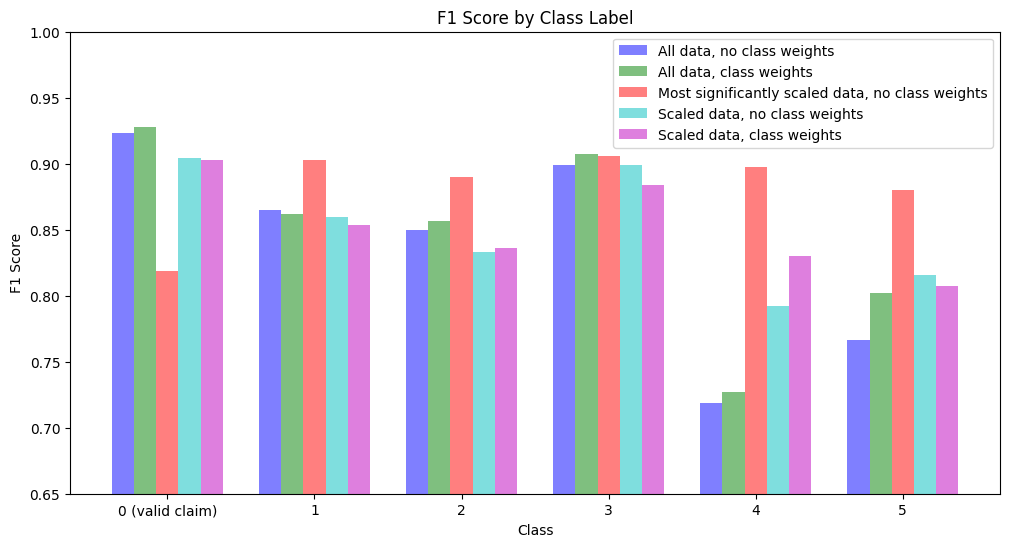

In [8]:
import numpy as np
import matplotlib.pyplot as plt

orig_data_no_weights = [0.92320306, 0.86486486, 0.84955752, 0.89915966, 0.71864407,
       0.76679842]
orig_data_weights = [0.92819518, 0.86166008, 0.85628743, 0.90763052, 0.72727273,
       0.80201765]
one_fifth_data_no_weights = [0.81900452, 0.90310078, 0.89014085, 0.90612245, 0.89772727, 0.88]
equal_data_no_weights = [0.90461804, 0.85984848, 0.83333333, 0.89878543, 0.79190751,
       0.81572482]
equal_data_weights = [0.90263955, 0.85380117, 0.83615819, 0.88372093, 0.83008357,
       0.80745342]

pos = np.arange(len(orig_data_no_weights))
width = 0.15

fig, ax = plt.subplots(figsize=(12,6))
plt.ylim(0.65, 1)
ax.bar(pos, orig_data_no_weights, width, alpha=0.5, color='b', label='All data, no class weights')
ax.bar(pos + width, orig_data_weights, width, alpha=0.5, color='g', label='All data, class weights')
ax.bar(pos + 2*width, one_fifth_data_no_weights, width, alpha=0.5, color='r', label='Most significantly scaled data, no class weights')
ax.bar(pos + 3*width, equal_data_no_weights, width, alpha=0.5, color='c', label='Scaled data, no class weights')
ax.bar(pos + 4*width, equal_data_weights, width, alpha=0.5, color='m', label='Scaled data, class weights')

ax.set_ylabel('F1 Score')
ax.set_xlabel('Class')
ax.set_title('F1 Score by Class Label')
ax.set_xticks(pos + 2*width)
ax.set_xticklabels(('0 (valid claim)', '1', '2', '3', '4', '5'))
ax.legend()

# Show the plot
plt.show()


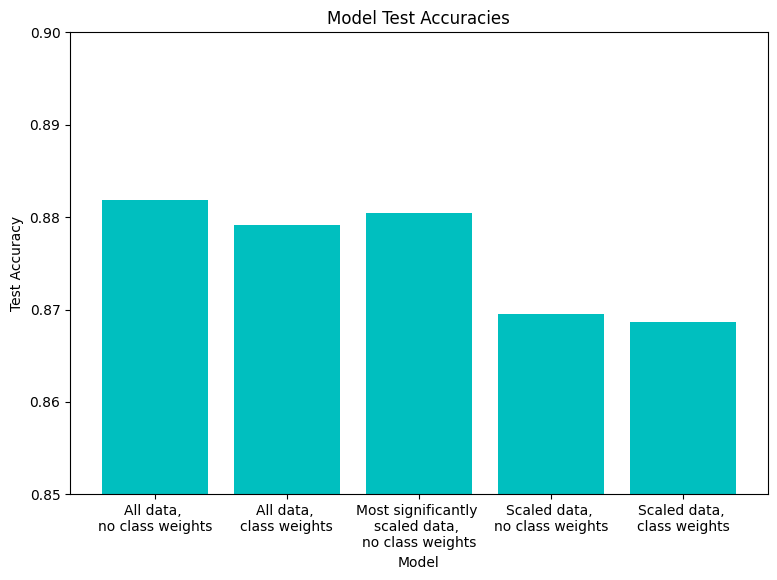

In [9]:
orig_data_no_weights_test_acc = 0.8818870523415978
orig_data_weights_test_acc = 0.8791322314049587
one_fifth_data_no_weights_test_acc = 0.8804347826086957
equal_data_no_weights_test_acc = 0.8695652173913043
equal_data_weights_test_acc = 0.8686956521739131   
plt.figure(figsize=(9,6))
plt.ylim(0.85, 0.9)
x = np.arange(5)
plt.bar(["All data, \nno class weights", "All data, \nclass weights", "Most significantly \nscaled data, \nno class weights", 'Scaled data, \nno class weights', 'Scaled data, \nclass weights'], [orig_data_no_weights_test_acc, orig_data_weights_test_acc, one_fifth_data_no_weights_test_acc, equal_data_no_weights_test_acc, equal_data_weights_test_acc], color='c')
plt.ylabel('Test Accuracy')
plt.xlabel('Model')
plt.title('Model Test Accuracies')

plt.show()

## Sanity Checks: Climate Skeptics Dataset

In [11]:
import ast
skeptics_data = pd.read_csv('https://raw.githubusercontent.com/livgimenes/climate-misinf-eeps1720/main/data/clean/climate_skeptics_all.csv?token=GHSAT0AAAAAAB5UTNPL7X6Y4HZKIFZ53EKUZCT2MQQ')

def join_lists(lst):
    return ' '.join(ast.literal_eval(lst))

skeptics_data['claim'] = skeptics_data['claim'].apply(join_lists).apply(denoise_text)

preds = model.predict(skeptics_data['claim'])

  0%|          | 0/655 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2545 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1242 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/102 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2247: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_pred, counts = mode(pred_row)


In [12]:
non_zero = preds[0][preds[0] != 0]
len(non_zero)

237

In [13]:
science_data = pd.read_csv('https://raw.githubusercontent.com/livgimenes/climate-misinf-eeps1720/main/data/clean/climate_scientist_all.csv?token=GHSAT0AAAAAAB5UTNPLVZU4IHUV65CA6DMUZCT2ODQ')
science_data['claim'] = science_data['claim'].apply(join_lists).apply(denoise_text)
preds_real = model.predict(science_data['claim'])

  0%|          | 0/698 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2306 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (654 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2247: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_pred, counts = mode(pred_row)


In [14]:
non_zero = preds_real[0][preds_real[0] != 0]
len(non_zero)

119

In [16]:
political_sub_data = pd.read_csv('https://raw.githubusercontent.com/livgimenes/climate-misinf-eeps1720/main/data/clean/political_posts.csv?token=GHSAT0AAAAAAB5UTNPLYZP2V752PSJK6MACZCT2O7Q')
political_sub_data['claim'] = political_sub_data['claim'].apply(join_lists).apply(denoise_text)
poli_preds = model.predict(political_sub_data['claim'])
political_sub_data['prediction'] = poli_preds[0]


  0%|          | 0/1314 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (792 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (792 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/788 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2247: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_pred, counts = mode(pred_row)


In [17]:
political_sub_data[political_sub_data['prediction'] != 0]

,claim,type,subreddit,prediction
4,I hear in the media on how the climate situati...,text,Libertarian,5
18,As a progressive watching climate change disas...,text,Libertarian,4
107,My favorite climate change fact. I feel like t...,text,Conservative,2
118,I am not sure if I am just completely clueless...,text,Liberal,4
138,"Duh. Yes, temperatures go up and down. How is ...",text,Anarcho_Capitalism,5
180,"Before Man had the idea to harness fire, Earth...",text,Objectivism,3
184,So here is a question that has been bugging me...,text,Objectivism,5
197,The US has decreased CO2 emissions to levels b...,text,Capitalism,4
209,The world is not ending. The planet is not goi...,text,Capitalism,5
221,"Mike Sommers, president and CEO of the powerfu...",text,Capitalism,4


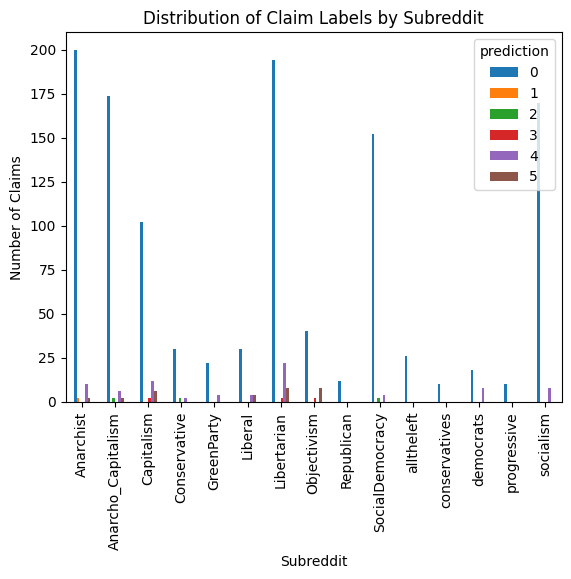

In [ ]:
# create a pivot table to count the number of claims for each subreddit and label
pivot = pd.pivot_table(political_sub_data, values='claim', index='subreddit', columns='prediction', aggfunc='count')

# create a stacked bar chart to show the distribution of claim labels by subreddit
pivot.plot(kind='bar', stacked=False)

# add labels and title to the chart
plt.xlabel('Subreddit')
plt.ylabel('Number of Claims')
plt.title('Distribution of Claim Labels by Subreddit')
plt.show()

In [ ]:
pivot = pivot.fillna(0)
#pivot = pivot.style.background_gradient(cmap='Blues')
pivot

prediction,0,1,2,3,4,5
subreddit,,,,,,
Anarchist,200.0,2.0,0.0,0.0,10.0,2.0
Anarcho_Capitalism,174.0,0.0,2.0,0.0,6.0,2.0
Capitalism,102.0,0.0,0.0,2.0,12.0,6.0
Conservative,30.0,0.0,2.0,0.0,2.0,0.0
GreenParty,22.0,0.0,0.0,0.0,4.0,0.0
Liberal,30.0,0.0,0.0,0.0,4.0,4.0
Libertarian,194.0,0.0,0.0,2.0,22.0,8.0
Objectivism,40.0,0.0,0.0,2.0,0.0,8.0
Republican,12.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
fix = political_sub_data[political_sub_data['subreddit'] == 'Libertarian']
fix = fix[fix['prediction'] == 5]
fix['claim']

351     What does Climate Denier mean? No I do not den...
1008    What does Climate Denier mean? No I do not den...
Name: claim, dtype: object